In [30]:
import pandas as pd
import numpy as np
from mytools import add_max_return, ema
import matplotlib.pyplot as plt
# import bisect
# %matplotlib notebook
%matplotlib inline
# import tensorflow

In [2]:
INTERVAL = pd.Timedelta('10s')
RETURN_HORIZON = INTERVAL*30
DATA_PATH = '/Users/felipe/bitcoin/{type}/{date}.csv.gz'
OUTPUT = '/Users/felipe/bitcoin/data/{date}-training.csv'
SPANS = [2, 3, 6, 15, 30, 60]  # in inverval units

In [3]:
FOR_DATE = '20190515'

In [4]:
def date_parser(string):
    return pd.Timestamp(f'{string[:10]} {string[11:]}')

def read_trades(date):
    date = str(date)
    path = DATA_PATH.format(type='trades', date=date)
    t = pd.read_csv(path,
                    index_col='timestamp',
                    parse_dates=True,
                    date_parser=date_parser,
                    usecols=['timestamp', 'symbol', 'price', 'side', 'size'])
    t.index.name = 'time'
    t = t[(t.symbol == 'XBTUSD') & (t.price > 1)]
    t = t.dropna()
    t.drop(columns={'symbol'}, inplace=True)
    t = t[['price', 'side', 'size']]
    return t

def read_quotes(date):
    date = str(date)
    path = DATA_PATH.format(type='quotes', date=date)
    t = pd.read_csv(path,
                    index_col='timestamp',
                    parse_dates=True,
                    date_parser=date_parser,
                    usecols=['timestamp', 'symbol', 'bidPrice', 'askPrice', 'bidSize', 'askSize'])
    t.index.name = 'time'
    t = t[(t.symbol == 'XBTUSD') & (t.bidPrice > 1) & (t.askPrice > 1) & (t.bidPrice < t.askPrice)]
    t = t.dropna()
    t.drop(columns={'symbol'}, inplace=True)
    t = t[['bidPrice', 'askPrice', 'bidSize', 'askSize']]
    return t

In [5]:
def process_trades(interval, return_horizon):
    t = read_trades(FOR_DATE)
    t.loc[t.side == 'Sell', 'size'] *= -1
    t.rename(columns={'size': 'boughtSum'}, inplace=True)
    t['soldSum'] = t['boughtSum'].copy()
    t = t[['boughtSum', 'soldSum']]
    t.loc[:, 'boughtSum'].clip(lower=0, inplace=True)
    t.loc[:, 'soldSum'].clip(upper=0, inplace=True)
    t['soldSum'] *= -1
    t = t.resample(interval).agg('sum').fillna(method='ffill')
    t = t[['boughtSum', 'soldSum']]
    # throw away first and last bucket, since they are incomplete
    t = t.iloc[1:-return_horizon//interval]
    return t

In [6]:
t = process_trades(INTERVAL, RETURN_HORIZON)
t.head()

,boughtSum,soldSum
time,,
2019-05-15 00:00:10,235036,12672
2019-05-15 00:00:20,1133215,54027
2019-05-15 00:00:30,209172,40211
2019-05-15 00:00:40,220380,12467
2019-05-15 00:00:50,171473,41690


In [10]:
def process_quotes(interval, return_horizon):
    q = read_quotes(FOR_DATE)
    q = q.resample(interval).agg('mean').fillna(method='ffill')
    q = q.rename(columns={c: f'{c}Avg' for c in q.columns})
    # it's better to compute max profit after avg to be conservative, i.e., no super high profit
    add_max_return(q, return_horizon, 'bidPriceAvg', 'askPriceAvg')
    q = q.iloc[1:-return_horizon//interval]
    return q

In [11]:
q = process_quotes(INTERVAL, RETURN_HORIZON)
q.head()

,bidPriceAvg,askPriceAvg,bidSizeAvg,askSizeAvg,maxLongReturn5min,maxShortReturn5min
time,,,,,,
2019-05-15 00:00:10,7997.915789,7998.447368,412589.821053,212751.684211,0.006940,-0.000066
2019-05-15 00:00:20,8000.128342,8000.700535,171407.636364,133618.652406,0.006724,-0.000072
2019-05-15 00:00:30,8009.545946,8010.148649,115792.097297,7946.335135,0.005582,-0.000075
2019-05-15 00:00:40,8014.451807,8014.957831,94688.421687,105447.301205,0.005833,-0.000063
2019-05-15 00:00:50,8014.500000,8015.000000,287964.657025,789264.004132,0.006735,-0.000062


In [14]:
len(q), len(t)

(8609, 8609)

In [41]:
df = pd.concat([t, q], axis=1).dropna()
Y_cols = list(df.columns[-2:])
X_cols = ['boughtSum', 'soldSum', 'bidPriceAvg', 'askPriceAvg', 'bidSizeAvg', 'askSizeAvg']
df = df[Y_cols + X_cols]

In [27]:
len(df), df.head()

(8609,                      maxLongReturn5min  maxShortReturn5min  boughtSum  \
 time                                                                    
 2019-05-15 00:00:10           0.006940           -0.000066     235036   
 2019-05-15 00:00:20           0.006724           -0.000072    1133215   
 2019-05-15 00:00:30           0.005582           -0.000075     209172   
 2019-05-15 00:00:40           0.005833           -0.000063     220380   
 2019-05-15 00:00:50           0.006735           -0.000062     171473   
 
                      soldSum  bidPriceAvg  askPriceAvg     bidSizeAvg  \
 time                                                                    
 2019-05-15 00:00:10    12672  7997.915789  7998.447368  412589.821053   
 2019-05-15 00:00:20    54027  8000.128342  8000.700535  171407.636364   
 2019-05-15 00:00:30    40211  8009.545946  8010.148649  115792.097297   
 2019-05-15 00:00:40    12467  8014.451807  8014.957831   94688.421687   
 2019-05-15 00:00:50    41690 

In [42]:
spans = [2, 3, 6, 15, 30, 60, 1000]

In [43]:
df = ema(df, spans, X_cols)

In [35]:
bidPrices = [i for i in df.columns if 'bidPriceAvg' in i]

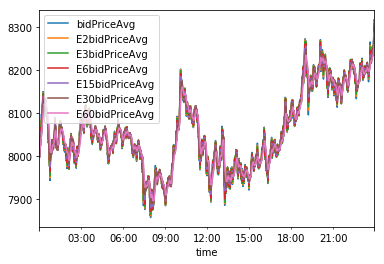

In [36]:
df[bidPrices].plot()

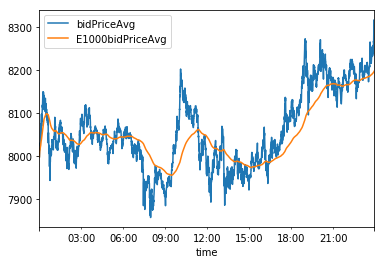

In [44]:
df[['bidPriceAvg', 'E1000bidPriceAvg']].plot()

In [72]:
df.to_csv(OUTPUT.format(date=FOR_DATE))

NameError: name 'df' is not defined

In [351]:
type(df.index)

pandas.core.indexes.datetimes.DatetimeIndex